In [6]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import scipy.stats as stats
from scipy.linalg import solve_discrete_lyapunov

from tqdm import trange

sys.path.append('../')

from examples.test_lds import main
from evaluations import gaussian_cdf_evaluation_PF, gaussian_cdf_evaluation_KF
from kalman_filtering import KalmanFilter
from environment_dynamics import LDSSimple

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
true_state_history, estimate_state_history, particle_history, weight_history, obs_history = main(
    seed=2, save_particles=True, num_iters=10, init="gaussian", num_particles=5000)

In [8]:
len(true_state_history)

10

In [9]:
theta = np.pi / 12
A = 0.99 * np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * 1.0
Gamma = np.eye(2) * 0.5

mu0 = np.array([10., 0.])
Gamma0 = np.eye(2) * 1.0

kf = KalmanFilter(A, C, Gamma, Sigma)

mu, V = kf.filtering(np.array(obs_history))

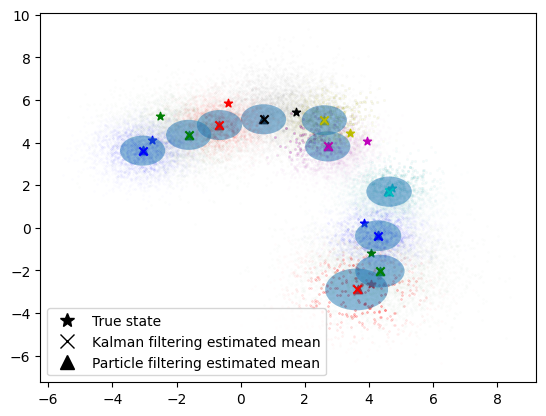

In [10]:
colors = 'rgbcmyk'

h = plt.subplot()

for i in range(10):
    plt.scatter(particle_history[i][:, 0], particle_history[i][:, 1], s=1, marker="x", label=str(i), alpha=0.01, color=colors[i%len(colors)])
    plt.scatter(np.array(true_state_history)[i, 0], np.array(true_state_history)[i, 1], color=colors[i%len(colors)], marker="*")
    plt.scatter(np.array(estimate_state_history)[i, 0], np.array(estimate_state_history)[i, 1], marker="^", color=colors[i%len(colors)])
    
    eigenvalues, eigenvectors = np.linalg.eigh(V[i])
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    ellipse = mpl.patches.Ellipse(xy=mu[i, :], width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]), angle=angle)
    ellipse.set_alpha(0.5)
    h.add_artist(ellipse)
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", color=colors[i%len(colors)])

true_states_patch = mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label='True state')
particle_filtering_estimate_patch = mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Kalman filtering estimated mean')
kalman_filtering_estimate_patch = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=10, label='Particle filtering estimated mean')
plt.legend(handles=[true_states_patch,particle_filtering_estimate_patch,kalman_filtering_estimate_patch])

In [14]:
particle_history, weight_history, true_state_history = [], [], []
with trange(100, dynamic_ncols=True) as pbar:
    for i in pbar:
        true_state_history_temp, estimate_state_history, particle_history_temp, weight_history_temp, obs_history = main(save_particles=True, init="gaussian", 
                                                                                                                        num_iters=20, num_particles=2000)
        particle_history.append(particle_history_temp)
        weight_history.append(weight_history_temp)
        true_state_history.append(true_state_history_temp)
particle_history = np.concatenate(particle_history, axis=0)
weight_history = np.concatenate(weight_history, axis=0)
true_state_history = np.concatenate(true_state_history, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


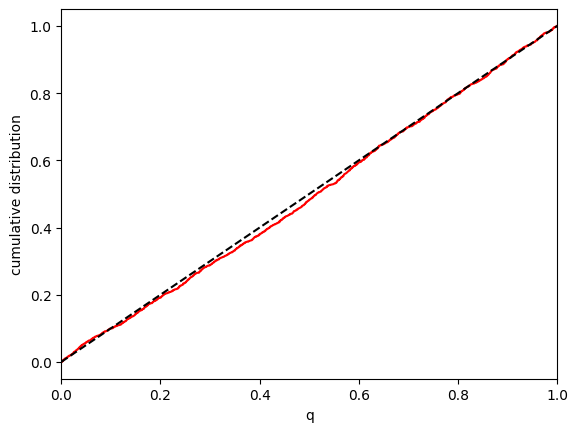

In [15]:
gaussian_cdf_evaluation_PF(particle_history, true_state_history, weight_history, dim=0)

In [23]:
theta = np.pi / 12
A = .99 * np.array([
[np.cos(theta), -np.sin(theta)], 
[np.sin(theta), np.cos(theta)], 
])
C = np.eye(2)

Sigma = np.eye(2) * .1
Gamma = np.eye(2) * 0.5

mu0 = np.zeros((2, ))
Gamma0 = solve_discrete_lyapunov(A, Gamma)

In [25]:
T = 20
N = 100
obs_seq = np.zeros((N, T, 2))
state_seq = np.zeros((N, T, 2))

for i in range(N):
    lds_env = LDSSimple(
        A=A, 
        C=C, 
        Gamma=Gamma, 
        Sigma=Sigma, 
    )
    for j in range(T):
        state_seq[i, j] = lds_env.curr_state
        obs_seq[i, j] = lds_env.obs_state()
        
        _ = lds_env.step()

In [34]:
mu_list = []
V_list = []

for n in range(N):

    kf = KalmanFilter(A, C, Gamma, Sigma)
    mu, V = kf.filtering(obs_seq[n])

    mu_list.append(mu.copy())
    V_list.append(V.copy())

mu_list = np.array(mu_list)
V_list = np.array(V_list)

In [32]:
particle_history_50, weight_history_50, true_state_history_50 = [], [], []
with trange(100, dynamic_ncols=True) as pbar:
    for i in pbar:
        true_state_history_temp, estimate_state_history, particle_history_temp, weight_history_temp, obs_history = main(save_particles=True, init="gaussian", 
                                                                                                                        num_iters=20, num_particles=2000)
        particle_history_50.append(particle_history_temp)
        weight_history_50.append(weight_history_temp)
        true_state_history_50.append(true_state_history_temp)
particle_history_50 = np.concatenate(particle_history_50, axis=0)
weight_history_50 = np.concatenate(weight_history_50, axis=0)
true_state_history_50 = np.concatenate(true_state_history_50, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


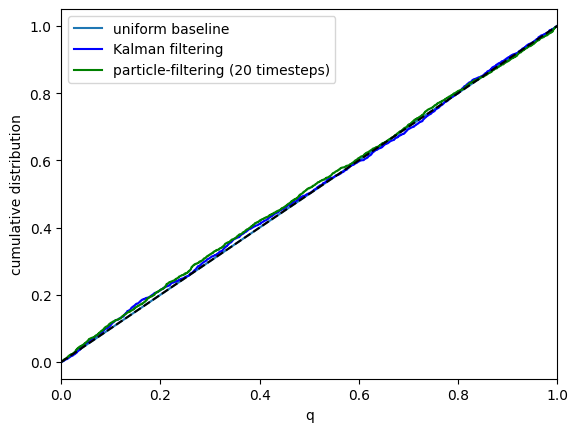

In [37]:
fig, ax = plt.subplots(1, 1)
ax.plot([0, 1], [0, 1], label="uniform baseline")

gaussian_cdf_evaluation_KF(mu_list, V_list, state_seq, dim=0, ax=ax, color="blue")
gaussian_cdf_evaluation_PF(particle_history_50, true_state_history_50, weight_history_50, dim=0, ax=ax, label="particle-filtering (20 timesteps)", color="green")

ax.legend()